In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import cv2 as cv
import time
import json

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
class TestDataset(datasets.ImageFolder):
  def __getitem__(self, index):
    path, target = self.samples[index]
    sample = self.loader(path)
    if self.transform is not None:
        sample = self.transform(sample)
    if self.target_transform is not None:
        target = self.target_transform(target)

    return sample, target, path

In [5]:
def calculate_test_scores(model, criterion, testloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model = model.to(device)
  model.eval()
  total_loss = 0.0
  corrects = 0
  predictions = {}

  checkpoint = 0
  num_viewed = 0
  N = len(testloader.dataset)

  # Iterate over data
  for data in testloader:
    inputs = data[0]
    labels = data[1]
    names = [i.split("/")[-1] for i in data[2]]
    inputs = inputs.to(device)
    labels = labels.to(device)
    #print(names)
    # Forward
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    # Statistics
    total_loss += loss.item() * inputs.size(0)
    corrects += torch.sum(preds == labels.data).item()

    num_viewed += inputs.size(0)

    for i in range(inputs.shape[0]):
      predictions[names[i]] = [preds[i].item(), labels[i].item()]

    if (10*num_viewed)//N > checkpoint:
      print(f"%{10*(checkpoint + 1)} of images are viewed.")
      checkpoint += 1


  avg_loss = total_loss / len(testloader.dataset)
  avg_acc = corrects / len(testloader.dataset)


  return avg_loss, avg_acc, predictions

In [6]:
def stop(val_metric, optimal = "minimal", patience = 5):
  if len(val_metric) <= patience:
    return False
  else:
    brk = True
    for i in range(patience, 0, -1):
      if optimal == "minimal":
        if val_metric[-i] < val_metric[-(patience + 1)]:
          brk = False
      else:
        if val_metric[-i] > val_metric[-(patience + 1)]:
          brk = False
    return brk


In [7]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    training_metrics = {"loss" : [], "accuracy": []}
    validation_metrics = {"loss" : [], "accuracy" : []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)


        # Each epoch has a training and validation phase
        for phase in ['train', 'validate']:

            print(f"Starting phase {phase}")

            start = time.time()
            checkpoint = 0
            num_viewed = 0

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            N = len(dataloaders[phase].dataset)


            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                num_viewed += inputs.size(0)

                if (10*num_viewed)//N > checkpoint:
                  print(f"%{10*(checkpoint + 1)} of images are viewed.")
                  checkpoint += 1

            epoch_loss = running_loss / N
            epoch_acc = running_corrects / N

            end = time.time()
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}, finished in {end - start:.3f} seconds')

            if phase == "train":
              training_metrics["loss"].append(epoch_loss)
              training_metrics["accuracy"].append(epoch_acc)
            elif phase == "validate":
              validation_metrics["loss"].append(epoch_loss)
              validation_metrics["accuracy"].append(epoch_acc)

            # Deep copy the model
            if phase == 'validate' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        #if phase == "train":
        #  scheduler.step(epoch_loss)

        if phase == "validate":
          scheduler.step(epoch_loss)
          if stop(validation_metrics["accuracy"], optimal = "maximal", patience = 6):
            break
        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_metrics, validation_metrics


In [8]:
root = "/content/gdrive/MyDrive/COMP448"
dataset_dir = os.path.join(root, "Dataset")
model_dir = os.path.join(root, "model_results")
os.chdir(root)

In [9]:

name = "preprocessed image model 2"
tr_dataname = "Train_p2"
val_dataname = "Validation_p2"
ts_dataname = "Test_p2"

log = f"Model Experiment Name: {name}\nTr_dataname : {tr_dataname}, Val_dataname : {val_dataname}, Ts_dataname : {ts_dataname}\n"


In [10]:
train_dir = os.path.join(dataset_dir, tr_dataname)
validate_dir = os.path.join(dataset_dir, val_dataname)
test_dir = os.path.join(dataset_dir, ts_dataname)

# Data transformations
data_transforms = {
    'Train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validation': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

test_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 30

##### log the transforms and batch_size  ######

log += "Tr_transforms : normalization, Val_transforms : normalization, Ts_transforms : normalization\n"
log += f"Batch_size : {batch_size}\n"

###############################


# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, transform=data_transforms['Train']),
    'validate': datasets.ImageFolder(validate_dir, transform=data_transforms['Validation'])
}

# Create data loaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size = batch_size, shuffle=True, num_workers=2),
    'validate': DataLoader(image_datasets['validate'], batch_size = batch_size, shuffle=False, num_workers=2)
}

In [11]:
# Define the device (use GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained model and reset the final fully connected layer
model = models.resnet18(weights = "DEFAULT")
modelname = "resnet18"


model.fc = nn.Linear(in_features=512, out_features=7, bias=True)
model = model.to(device)

# Define the loss function and optimizer

learning_rate = 0.001
momentum = 0.96
scheduler_patience = 3
scheduler_factor = 0.1

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = scheduler_patience, factor = scheduler_factor)

max_num_epochs = 50

######### log the model info ##################

log += f"Model : {modelname}, Criterion : CrossEntropyLoss, Optimizer : SGD(lr = {learning_rate}, momentum = {momentum}), scheduler = ReduceLROnPlateau(patience = {scheduler_patience}, factor = {scheduler_factor}), max_num_epochs = {max_num_epochs}\n"

##############################################

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 154MB/s]


In [12]:
print(log)

Model Experiment Name: preprocessed image model 2
Tr_dataname : Train_p2, Val_dataname : Validation_p2, Ts_dataname : Test_p2
Tr_transforms : normalization, Val_transforms : normalization, Ts_transforms : normalization
Batch_size : 30
Model : resnet18, Criterion : CrossEntropyLoss, Optimizer : SGD(lr = 0.001, momentum = 0.96), scheduler = ReduceLROnPlateau(patience = 3, factor = 0.1), max_num_epochs = 50



In [13]:
model, tr_metrics, val_metrics = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs = max_num_epochs)

Epoch 0/49
----------
Starting phase train
%10 of images are viewed.
%20 of images are viewed.
%30 of images are viewed.
%40 of images are viewed.
%50 of images are viewed.
%60 of images are viewed.
%70 of images are viewed.
%80 of images are viewed.
%90 of images are viewed.
%100 of images are viewed.
train Loss: 1.2387 Acc: 0.5341, finished in 587.132 seconds
Starting phase validate
%10 of images are viewed.
%20 of images are viewed.
%30 of images are viewed.
%40 of images are viewed.
%50 of images are viewed.
%60 of images are viewed.
%70 of images are viewed.
validate Loss: 0.8361 Acc: 0.6943, finished in 30.104 seconds

Epoch 1/49
----------
Starting phase train
%10 of images are viewed.
%20 of images are viewed.
%30 of images are viewed.
%40 of images are viewed.
%50 of images are viewed.
%60 of images are viewed.
%70 of images are viewed.
%80 of images are viewed.
%90 of images are viewed.
%100 of images are viewed.
train Loss: 0.7612 Acc: 0.7170, finished in 89.053 seconds
Star

In [ ]:
tr_loss = np.array(tr_metrics["loss"])
val_loss = np.array(val_metrics["loss"])
tr_accuracy = np.array(tr_metrics["accuracy"])
val_accuracy = np.array(val_metrics["accuracy"])

training_info = np.hstack([tr_loss[:,None], tr_accuracy[:,None], val_loss[:,None], val_accuracy[:,None]])

In [ ]:
training_info

array([[1.20439739, 0.55045872, 0.92178997, 0.68393782],
       [0.7657973 , 0.71340247, 0.68044812, 0.78756477],
       [0.56441806, 0.79377742, 0.5155531 , 0.8134715 ],
       [0.4419035 , 0.83984842, 0.73167135, 0.74093264],
       [0.31873261, 0.88332669, 0.66398345, 0.77202073],
       [0.23063844, 0.91862784, 1.00035086, 0.69948187],
       [0.15992847, 0.94714799, 0.45113374, 0.88601036],
       [0.10496847, 0.96769047, 0.64038136, 0.8134715 ],
       [0.06327042, 0.98304747, 0.70018442, 0.80310881],
       [0.06317164, 0.98304747, 1.02378872, 0.75647668],
       [0.07313491, 0.97586757, 0.87196449, 0.76683938],
       [0.02996456, 0.9918229 , 0.61274312, 0.83937824],
       [0.01879736, 0.9976067 , 0.55196598, 0.83419689]])

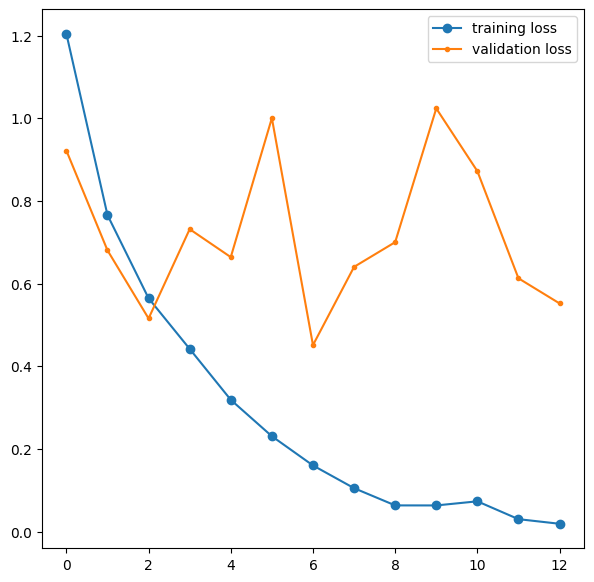

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(np.arange(training_info.shape[0]), training_info[:,0], "o-", label = "training loss")
plt.plot(np.arange(training_info.shape[0]), training_info[:,2], ".-", label = "validation loss")
plt.legend()
plt.show()

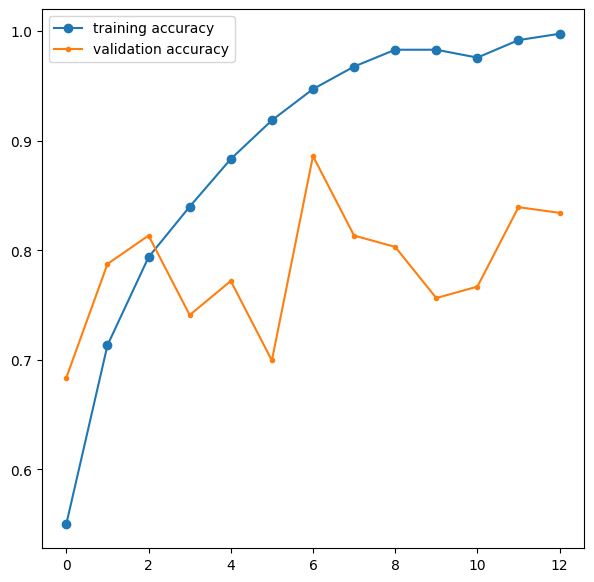

In [ ]:
plt.figure(figsize = (7,7))
plt.plot(np.arange(training_info.shape[0]), training_info[:,1], "o-", label = "training accuracy")
plt.plot(np.arange(training_info.shape[0]), training_info[:,3], ".-", label = "validation accuracy")
plt.legend()
plt.show()

In [ ]:
test_dataset = TestDataset(test_dir, transform=test_transforms)

test_loader =  DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

avg_loss, avg_acc, preds = calculate_test_scores(model, criterion, test_loader)
print(avg_acc)

%10 of images are viewed.
%20 of images are viewed.
%30 of images are viewed.
%40 of images are viewed.
%50 of images are viewed.
%60 of images are viewed.
%70 of images are viewed.
%80 of images are viewed.
%90 of images are viewed.
%100 of images are viewed.
0.7761685319289006


In [ ]:
log += f"Test accuracy : {avg_acc}"

In [ ]:
print(log)

Model Experiment Name: preprocessed image model 2
Tr_dataname : Train_p2, Val_dataname : Validation_p2, Ts_dataname : Test_p2
Tr_transforms : normalization, Val_transforms : normalization, Ts_transforms : normalization
Batch_size : 30
Model : resnet18, Criterion : CrossEntropyLoss, Optimizer : SGD(lr = 0.001, momentum = 0.96), scheduler = ReduceLROnPlateau(patience = 3, factor = 0.1), max_num_epochs = 50
Test accuracy : 0.7761685319289006


In [ ]:
modelversion = "model" + f"{len(os.listdir(model_dir)) + 1}"

os.mkdir(os.path.join(model_dir, modelversion))

with open(os.path.join(model_dir, modelversion, "info.txt"), "w") as f:
  f.write(log)

np.savetxt(os.path.join(model_dir, modelversion, "training_info.txt"), training_info)

with open(os.path.join(model_dir, modelversion, "preds.json"), "w") as f:
  json.dump(preds, f)

In [ ]:
torch.save(model.state_dict(), os.path.join(model_dir, modelversion, "model.pt"))